In [177]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import os
import cv2
from scipy import ndimage as ndi

from skimage import img_as_float, measure, filters
from skimage.filters import gaussian
from skimage.transform import resize

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.ndimage import binary_fill_holes

os.environ['LOKY_MAX_CPU_COUNT'] = '8'


In [178]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [179]:
data_train_path = Path('data/images_hTE3Lse/images')
data_test_path = Path('data/images_ZKlXDOZ/images')
label_path = Path('data/label_rphifOX.csv')

data_train = load_dataset(data_train_path)
print("Loaded data_train:", data_train.shape)
data_test = load_dataset(data_test_path)
print("Loaded data_test:", data_test.shape)

Loaded data_train: (2000, 512, 512)
Loaded data_test: (500, 512, 512)


In [227]:
import pandas as pd

# Load half-supervised labels
labels = pd.read_csv(
    'data/label_rphifOX.csv',
    index_col=0,
)
print("Loaded labels:", labels.shape)
labels = labels.T
labels.head()

Loaded labels: (262144, 2000)


,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


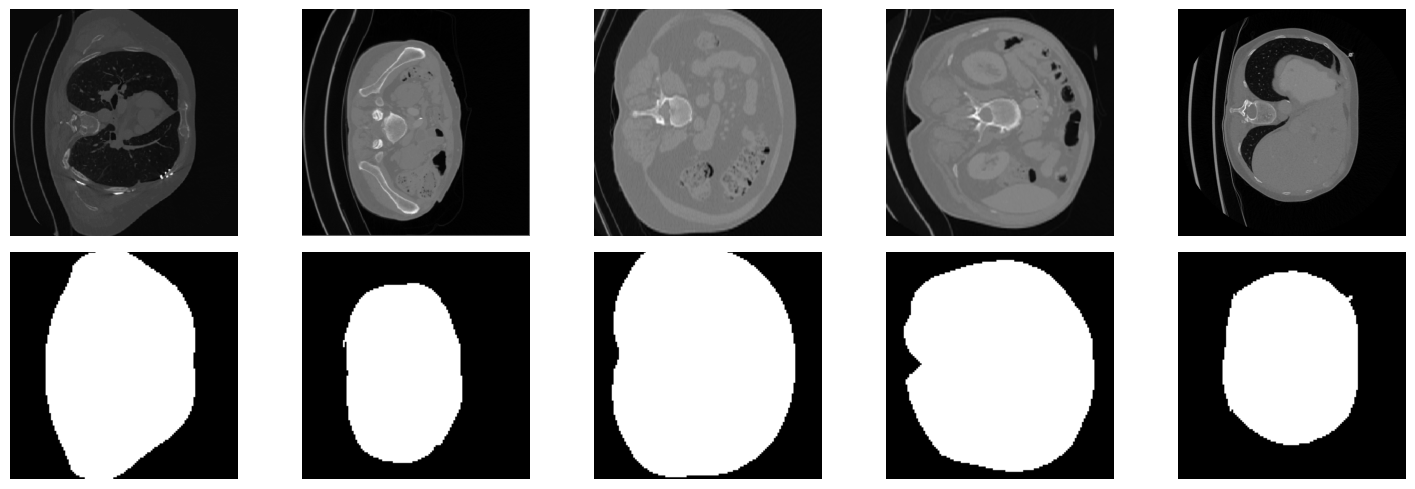

In [266]:
def preprocess_image(image):
    image_float = img_as_float(image)
    smoothed = gaussian(image_float, sigma=1)
    smoothed_uint8 = (smoothed * 255).astype("uint8")
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(smoothed_uint8)
    normalized = equalized / 255.0
    denoised = ndi.median_filter(normalized, size=5)
    resized = resize(denoised, (128, 128), anti_aliasing=True)
    return resized

def get_ROI(image):
    preprocessed_image = preprocess_image(image)
    threshold = filters.threshold_otsu(preprocessed_image)
    binary_mask = preprocessed_image > threshold
    labeled_mask = measure.label(binary_mask)
    regions = measure.regionprops(labeled_mask)
    largest_region = max(regions, key=lambda r: r.area)  # Find the largest region
    continuous_mask = labeled_mask == largest_region.label
    filled_mask = binary_fill_holes(continuous_mask)
    return filled_mask

def quantize_img(img, N):
    quantized_img = np.floor(img * N).astype(np.uint8)
    quantized_img[quantized_img == N] = N - 1  
    return quantized_img

# Test the function on 5 random images and plot them
fig, axes = plt.subplots(2,5, figsize=(15, 5))

for i in range(5):
    image = data_train[np.random.randint(0, data_train.shape[0])]
    roi = get_ROI(image)
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(roi, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


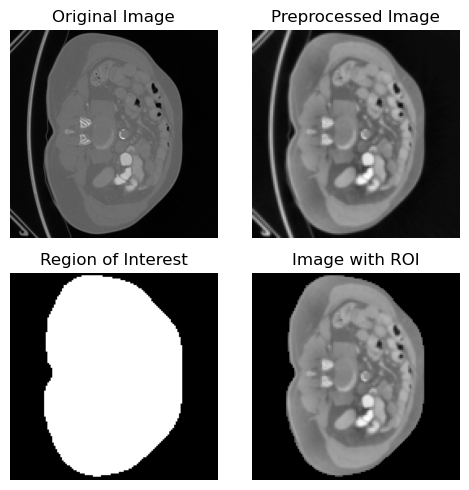

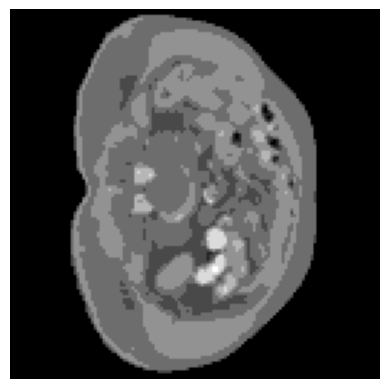

In [206]:
img_test = data_train[0]
img_test_prep = preprocess_image(img_test)
img_test_roi = get_ROI(img_test)
img_test_with_roi = img_test_prep * img_test_roi
img_test_quantized = quantize_img(img_test_with_roi, 8)

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].imshow(img_test, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')
axs[0, 1].imshow(img_test_prep, cmap='gray')
axs[0, 1].set_title('Preprocessed Image')
axs[0, 1].axis('off')
axs[1, 0].imshow(img_test_roi, cmap='gray')
axs[1, 0].set_title('Region of Interest')
axs[1, 0].axis('off')
axs[1, 1].imshow(img_test_with_roi, cmap='gray')
axs[1, 1].set_title('Image with ROI')
axs[1, 1].axis('off')
fig.tight_layout()
plt.show()

plt.imshow(img_test_quantized, cmap='gray')
plt.axis('off')
plt.show()


k=20 took 3.44 seconds
k=30 took 5.65 seconds
k=40 took 7.96 seconds
k=50 took 7.80 seconds
k=60 took 9.88 seconds


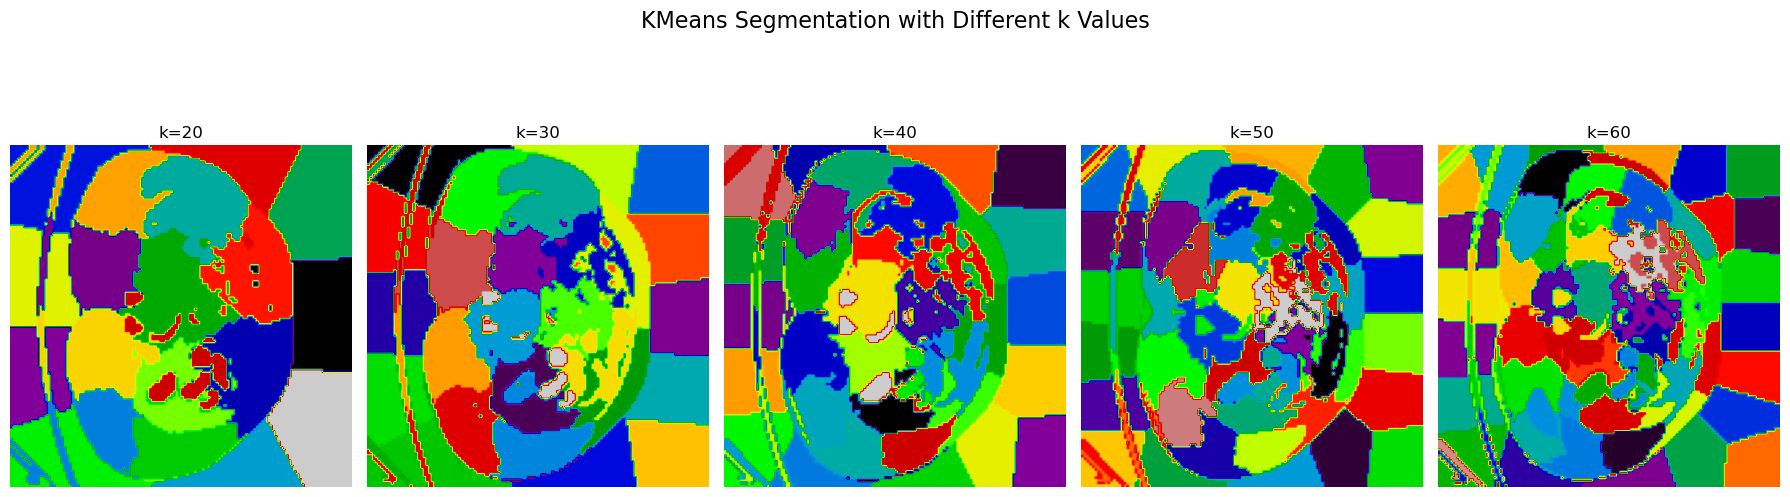

In [ ]:
"""
k_values = [20, 30, 40, 50, 60]

height, width = img_test_prep.shape
pixel_values = img_test_prep.flatten()

X, Y = np.meshgrid(np.arange(width), np.arange(height))
X = X.flatten()
Y = Y.flatten()

features = np.stack((pixel_values, X, Y), axis=-1)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

fig, axs = plt.subplots(1, len(k_values), figsize=(18, 6))
fig.suptitle('KMeans Segmentation with Different k Values', fontsize=16)

for i, k in enumerate(k_values):
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, n_init=25, tol=0.00001, algorithm='elkan')
    kmeans.fit(features_scaled)
    cluster_labels = kmeans.labels_

    img_seg_km = cluster_labels.reshape(height, width)
    end_time = time.time()
    print(f'k={k} took {end_time - start_time:.2f} seconds')
    

    axs[i].imshow(img_seg_km, cmap='nipy_spectral')
    axs[i].set_title(f'k={k}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()
"""


In [250]:
kmeans = KMeans(n_clusters=100, n_init=25, tol=0.00001, algorithm='elkan')
kmeans.fit(features_scaled)
cluster_labels = kmeans.labels_
img_seg_km = cluster_labels.reshape(height, width)

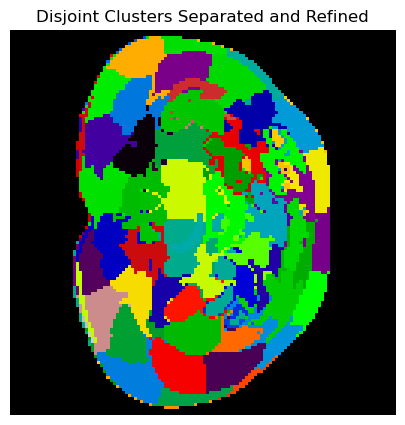

In [251]:
from skimage.measure import label as sk_label

def separate_disjoint_clusters(kmeans_labels):
    separated_clusters = np.zeros_like(kmeans_labels, dtype=int)
    new_label = 1  # Start from 1 to avoid using 0
    unique_labels = np.unique(kmeans_labels)
    for label_value in unique_labels:
        if label_value == 0:
            continue
        cluster_mask = (kmeans_labels == label_value)
        connected_components = sk_label(cluster_mask, connectivity=1)
        for component_label in np.unique(connected_components):
            if component_label == 0:
                continue
            separated_clusters[connected_components == component_label] = new_label
            new_label += 1
    return separated_clusters

def refine_kmeans_with_roi(kmeans_labels, roi_mask):
    refined_labels = np.copy(kmeans_labels)
    refined_labels[~roi_mask] = 0
    unique_labels, new_labels = np.unique(refined_labels, return_inverse=True)
    new_labels = new_labels + 1  # Shift labels to avoid using 0
    refined_labels = new_labels.reshape(refined_labels.shape)
    refined_labels[~roi_mask] = 0  # Ensure background is still 0
    return refined_labels

img_seg_km2 = refine_kmeans_with_roi(separate_disjoint_clusters(img_seg_km), img_test_roi)

plt.figure(figsize=(10, 5))
plt.imshow(img_seg_km2, cmap='nipy_spectral')
plt.title('Disjoint Clusters Separated and Refined')
plt.axis('off')
plt.show()


In [252]:
unique, counts = np.unique(img_seg_km2, return_counts=True)
print(unique)
print(counts)

[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

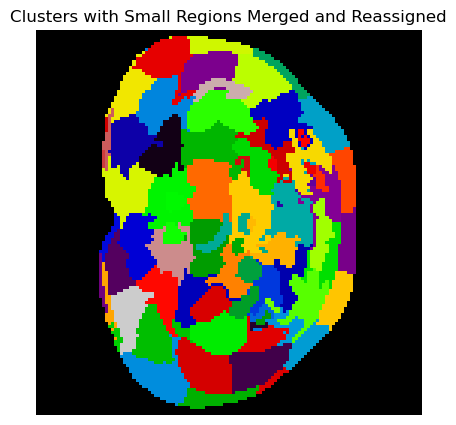

Cluster labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]
Cluster sizes: [7852  184   10  209  125   25  109  179    4  124    1    1    6    1
    3  199  108  136  214    2  183   32    1  101    2   22    3    1
  211  230   20   39   94  156    1    5    1  226    1   53   22    4
    1   68   56   59   12  164    2   19  103  222  179   23   14    5
  139   80   14  201  204   36   40  229  178   12  102  203    1   90
  217    1    4  138    3  150    2  231  126   10  110   38    2  117
  261  122   23  167   15   12   12  211   96   25  107  241    5  114
   19    6   32  163   78  170]


In [253]:
from skimage.measure import label as sk_label, regionprops
from scipy.ndimage import binary_fill_holes

def remove_small_clusters(segmented_image, min_size=50):
    refined_image = np.copy(segmented_image)
    unique_labels = np.unique(segmented_image)

    for label_value in unique_labels:
        if label_value == 0:
            continue

        cluster_mask = (segmented_image == label_value)
        connected_components = sk_label(cluster_mask, connectivity=1)
        regions = regionprops(connected_components)

        for region in regions:
            if region.area < min_size:
                coords = region.coords
                for y, x in coords:
                    neighbors = refined_image[max(0, y - 1):y + 2, max(0, x - 1):x + 2]
                    neighboring_labels = np.unique(neighbors[(neighbors != label_value) & (neighbors != 0)])

                    if len(neighboring_labels) > 0:
                        refined_image[y, x] = neighboring_labels[0]
                    else:
                        refined_image[y, x] = label_value

    unique_labels, new_labels = np.unique(refined_image, return_inverse=True)
    refined_image = new_labels.reshape(refined_image.shape)

    return refined_image

img_seg_km3 = remove_small_clusters(img_seg_km2, min_size=10)

plt.figure(figsize=(10, 5))
plt.imshow(img_seg_km3, cmap='nipy_spectral')
plt.title('Clusters with Small Regions Merged and Reassigned')
plt.axis('off')
plt.show()

unique, counts = np.unique(img_seg_km3, return_counts=True)
print("Cluster labels:", unique)
print("Cluster sizes:", counts)


In [254]:
img_test_quantized[50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 4, 4, 5,
       5, 5, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

C:\Users\sacha\AppData\Local\Temp\ipykernel_10436\3272929926.py:115: RuntimeWarning: divide by zero encountered in scalar divide
  if boundary_length / perimeter >= 0.5:  # Adjust threshold as needed


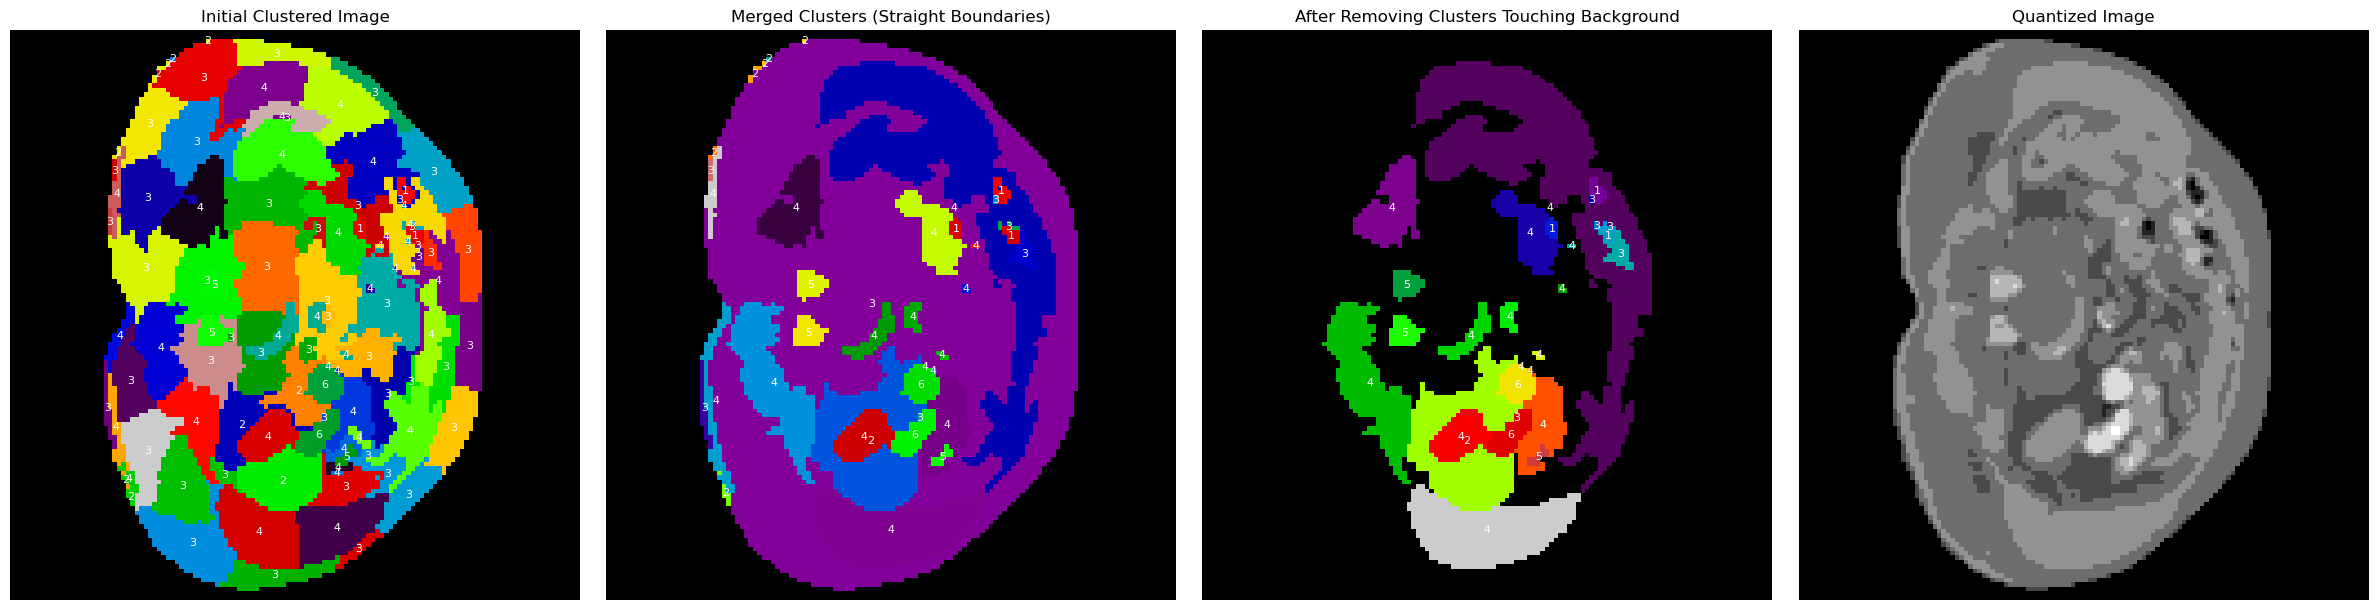

KeyError: '0'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from skimage.measure import regionprops, label
import networkx as nx
from sklearn.linear_model import LinearRegression
from skimage.measure import label as sk_label

def calculate_cluster_modes(segmented_image, quantized_image):
    cluster_modes = {}
    unique_labels = np.unique(segmented_image)
    
    for label_value in unique_labels:
        if label_value == 0:
            continue  # Skip background
        cluster_mask = (segmented_image == label_value)
        quantized_values = quantized_image[cluster_mask]
        if quantized_values.size > 0:
            counts = np.bincount(quantized_values)
            mode_value = np.argmax(counts)
            cluster_modes[label_value] = mode_value
        else:
            cluster_modes[label_value] = None  # No valid pixels in cluster
    return cluster_modes

cluster_modes = calculate_cluster_modes(img_seg_km3, img_test_quantized)

def is_boundary_straight(boundary_coords, tolerance=2):
    """
    Determines if a boundary is approximately a straight line.
    Uses linear regression and calculates the residuals.
    """
    if boundary_coords.shape[0] < 2:
        return False  # Not enough points to form a line
    
    y = boundary_coords[:, 0].reshape(-1, 1)
    x = boundary_coords[:, 1]
    model = LinearRegression()
    model.fit(y, x)
    x_pred = model.predict(y)
    residuals = np.abs(x - x_pred)
    mean_residual = np.mean(residuals)
    return mean_residual <= tolerance

def merge_clusters_based_on_quantized_values(segmented_image, cluster_modes, tolerance=2):
    """
    Merge adjacent clusters that have the same quantized value and share a straight-line boundary.
    """
    G = nx.Graph()
    labels = np.unique(segmented_image)
    G.add_nodes_from(labels)
    
    shifts = [(-1,0), (1,0), (0,-1), (0,1)]
    neighbor_boundaries = {}

    for dy, dx in shifts:
        shifted_labels = np.roll(segmented_image, shift=(dy, dx), axis=(0,1))
        mask = (segmented_image != shifted_labels)
        y_indices, x_indices = np.where(mask)
        labels1 = segmented_image[mask]
        labels2 = shifted_labels[mask]
        for a, b, y, x in zip(labels1, labels2, y_indices, x_indices):
            if a != b:
                pair = (min(a,b), max(a,b))
                neighbor_boundaries.setdefault(pair, []).append((y, x))
    
    for (a, b), boundary_pixels in neighbor_boundaries.items():
        if cluster_modes.get(a) == cluster_modes.get(b) and cluster_modes.get(a) is not None:
            boundary_coords = np.array(boundary_pixels)
            if is_boundary_straight(boundary_coords, tolerance=tolerance):
                G.add_edge(a, b)
    
    # Merge clusters
    merged_clusters = list(nx.connected_components(G))
    label_mapping = {}
    for new_label, cluster in enumerate(merged_clusters):
        for label in cluster:
            label_mapping[label] = new_label

    merged_image = np.copy(segmented_image)
    for old_label, new_label in label_mapping.items():
        merged_image[segmented_image == old_label] = new_label

    return merged_image

# Merge clusters based on quantized values and straight-line boundaries
merged_image = merge_clusters_based_on_quantized_values(img_seg_km3, cluster_modes, tolerance=2)

def remove_clusters_touching_background(segmented_image, min_background_boundary=30):
    """
    Transform clusters that share a significant boundary with the background into background.
    """
    # Find boundaries between clusters
    shifts = [(-1,0), (1,0), (0,-1), (0,1)]
    neighbor_boundaries = {}
    for dy, dx in shifts:
        shifted_labels = np.roll(segmented_image, shift=(dy, dx), axis=(0,1))
        mask = (segmented_image != shifted_labels)
        labels1 = segmented_image[mask]
        labels2 = shifted_labels[mask]
        for a, b in zip(labels1, labels2):
            if a == 0 or b == 0:
                non_zero_label = b if a == 0 else a
                neighbor_boundaries[non_zero_label] = neighbor_boundaries.get(non_zero_label, 0) + 1
    
    # Get cluster properties
    props = regionprops(segmented_image)
    cluster_perimeters = {prop.label: prop.perimeter for prop in props if prop.label != 0}
    
    # Identify clusters to remove
    clusters_to_remove = []
    for label, boundary_length in neighbor_boundaries.items():
        perimeter = cluster_perimeters.get(label, 1)
        # If boundary length with background is significant compared to cluster perimeter
        if boundary_length / perimeter >= 0.5:  # Adjust threshold as needed
            clusters_to_remove.append(label)
    
    # Remove clusters by setting them to background
    cleaned_image = np.copy(segmented_image)
    for label in clusters_to_remove:
        cleaned_image[segmented_image == label] = 0
    
    # Relabel to ensure contiguous labels
    cleaned_image = sk_label(cleaned_image, background=0)
    return cleaned_image

# Remove clusters touching background significantly
final_image = remove_clusters_touching_background(merged_image, min_background_boundary=30)

def overlay_cluster_modes(ax, segmented_image, cluster_modes):
    props = regionprops(segmented_image)
    for prop in props:
        label_value = prop.label
        if label_value == 0:
            continue
        y0, x0 = prop.centroid
        mode_value = cluster_modes.get(label_value)
        if mode_value is not None:
            ax.text(x0, y0, f'{mode_value}', color='white', fontsize=8, ha='center', va='center')

# Visualize the results
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Initial clustered image
axs[0].imshow(img_seg_km3, cmap='nipy_spectral')
axs[0].set_title('Initial Clustered Image')
axs[0].axis('off')
overlay_cluster_modes(axs[0], img_seg_km3, cluster_modes)

# Merged image after step 1
merged_cluster_modes = calculate_cluster_modes(merged_image, img_test_quantized)
axs[1].imshow(merged_image, cmap='nipy_spectral')
axs[1].set_title('Merged Clusters (Straight Boundaries)')
axs[1].axis('off')
overlay_cluster_modes(axs[1], merged_image, merged_cluster_modes)

# Final image after removing clusters touching background
final_cluster_modes = calculate_cluster_modes(final_image, img_test_quantized)
axs[2].imshow(final_image, cmap='nipy_spectral')
axs[2].set_title('After Removing Clusters Touching Background')
axs[2].axis('off')
overlay_cluster_modes(axs[2], final_image, final_cluster_modes)

# Quantized image
axs[3].imshow(img_test_quantized, cmap='gray')
axs[3].set_title('Quantized Image')
axs[3].axis('off')

plt.tight_layout()
plt.show()
